# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations
import random
import re

In [2]:
df = pd.read_csv('../data/raw-data/lyrics-data.csv')
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [3]:
df_art = pd.read_csv('../data/raw-data/artists-data.csv')
df_art.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [4]:
df = df[df['language']=='en'].reset_index(drop=True)

## Class Label Preparation: Genre

In [5]:
genres = []
for artist_id in tqdm(df['ALink']):    
    artist_row = df_art[df_art['Link']==artist_id].reset_index()
    try:
        genres_in_artist = artist_row['Genres'][0].split('; ')        
    except:
        genres_in_artist = []
    genres.append(genres_in_artist)

100%|██████████| 191814/191814 [02:45<00:00, 1156.71it/s]


In [6]:
df.drop(columns = ['ALink', 'SName', 'SLink', 'language'], inplace=True)
df.rename(columns={'Lyric': 'lyrics'}, inplace=True)

In [7]:
genres = pd.Series(genres)
# Convert nested list into one-hot-encoding
mlb = MultiLabelBinarizer()
genres_one_hot = pd.DataFrame(mlb.fit_transform(genres),
                    columns=mlb.classes_,
                    index=genres.index)
genres_one_hot.head()

,Axé,Black Music,Blues,Bossa Nova,COLETÂNEA,Chillout,Classic Rock,Clássico,Country,Dance,...,Soul Music,Surf Music,Tecnopop,Trance,Trap,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
genres_one_hot.sum().sort_values(ascending=False)[:10]

Rock           63717
Pop            33571
Pop/Rock       26360
Heavy Metal    21759
Hip Hop        20902
Indie          20134
Romântico      17947
Hard Rock      17250
Rap            17114
R&B            15581
dtype: int64

In [9]:
# Keep only the 8 most frequent genres (some of them will also be merged)
genres2keep = genres_one_hot.sum().sort_values(ascending=False)[:9].keys()

# Format labels
format_label = lambda s: s.lower().replace(' ', '-').replace('/', '-')

genres_one_hot = genres_one_hot[genres2keep]
genres_one_hot.rename(columns = dict([(
    genre_label, format_label(genre_label)) 
    for genre_label in genres_one_hot.keys()]), inplace=True)

In [10]:
df = pd.concat([df, genres_one_hot], axis=1)

In [11]:
genre_labels = [label for label in df.keys() if label != 'lyrics']

# Remove lyrics that do not fit into the main genres
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [12]:
jaccard_similarity = lambda x, y: np.logical_and(x, y).sum() / np.logical_or(x, y).sum()

genre_pairs = list(combinations(genre_labels, 2))

genre_similarities = [jaccard_similarity(df[genre_pair[0]], df[genre_pair[1]]) 
    for genre_pair in genre_pairs]

sorted(list(zip(genre_pairs, genre_similarities)),
    reverse=True, key=lambda x: x[1])[:20]

[(('hip-hop', 'rap'), 0.5317297231959386),
 (('heavy-metal', 'hard-rock'), 0.29537756525204223),
 (('rock', 'hard-rock'), 0.2094735898661568),
 (('pop', 'pop-rock'), 0.20258854218922445),
 (('rock', 'heavy-metal'), 0.15670672296200064),
 (('pop', 'romântico'), 0.13970311704975333),
 (('rock', 'pop-rock'), 0.13782431852057703),
 (('pop-rock', 'romântico'), 0.10936678434612784),
 (('rock', 'indie'), 0.10295433021151215),
 (('pop', 'hip-hop'), 0.058550330353672755),
 (('rock', 'romântico'), 0.0391540585593037),
 (('pop-rock', 'indie'), 0.03575486199291586),
 (('pop', 'rap'), 0.03301742586365026),
 (('pop', 'indie'), 0.02956118321415563),
 (('rock', 'pop'), 0.029502645502645503),
 (('indie', 'romântico'), 0.029299672946455118),
 (('pop-rock', 'hard-rock'), 0.012772875058058523),
 (('rock', 'hip-hop'), 0.007644950403086559),
 (('indie', 'hard-rock'), 0.007030681787571048),
 (('romântico', 'hard-rock'), 0.005513655582219175)]

In [13]:
# Merge together rap and hip hop
df['rap'] = np.logical_or(df['rap'], df['hip-hop']).replace({True: 1, False: 0})
# Drop columns
df.drop(columns=['romântico'], inplace=True)
df.drop(columns=['hip-hop'], inplace=True)
# Remove again lyrics that do not fit into the genres kept
genre_labels = [label for label in df.keys() if label != 'lyrics']
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [14]:
# Get unique labels and compute value counts
df[df[genre_labels].sum(axis=1) == 1][genre_labels].sum(axis=0)

rock           26201
pop            17770
pop-rock        6011
heavy-metal     8447
indie           9468
hard-rock       1460
rap            20185
dtype: int64

In [15]:
# Drop songs with multiple genres
df.drop(df[df[genre_labels].sum(axis=1) > 1].index, inplace=True)
# Keep only rock, pop and rap lyrics:
# 1) Remove columns
df.drop(columns=['pop-rock','heavy-metal','indie','hard-rock'], inplace=True)
# 2) Remove rows
genre_labels = [label for label in df.keys() if label != 'lyrics']
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [16]:
# Duplicates are songs with multiple artists (e.g. a featuring)
# Remove duplicates having the same genre
print(f'Duplicates with the same genre: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
# Remove lyrics with different genres among duplicates:
print(f'Duplicates with different genres: {df.duplicated(subset="lyrics").sum()}')
df.drop_duplicates(subset="lyrics", keep=False, inplace=True)

Duplicates with the same genre: 349
Duplicates with different genres: 90


In [17]:
df[genre_labels].sum(axis=0)

rock    26082
pop     17576
rap     19969
dtype: int64

In [18]:
df.reset_index(inplace=True, drop=True)

## Text Cleaning

In [19]:
rand = random.choice(df['lyrics'])
rand

"I can't explain\nCan't quite put my finger on\nThe difference that makes us so different\nWe've said everything... our words only betray us\nNothing is left... nothing was left unsaid\n\nThis time... I have nothing left to lose\nI'm stuck... the second hand won't move\nIt's about time that I speak my mind\nIt's about time... about time I find\nPieces of me I have lost\nWithout any choice I move on\nHey time you're no friend of mine\nHey time you're no friend of mine\n\nYou cover yourself... you cover your skin\nYou cover yourself... like you cover your sin\nPlease untie my hands... I'm a sinner... I'm a man\nI ask for one minute... to make you understand\n\nThis time... I have nothing left to lose\nI'm stuck... the second hand won't move\nIt's about time that I speak my mind\nIt's about time... about time I find\nPieces of me I have lost\nWithout any choice I move on\nHey time you're no friend of mine\nHey time you're no friend of mine\n\nWill you be there to catch me when I stumble\n

In [20]:
def clean_text(lyrics):
    lyrics = re.sub(r'\((.+?)?\)', '', lyrics)
    lyrics = re.sub(r'\[(.+?)?\]', '', lyrics)
    lyrics = re.sub(r'\{(.+?)?\}', '', lyrics)
    lyrics = re.sub(r'\n+', '\n', lyrics)
    lyrics = re.sub(r'^[^a-zA-Z]+$', '', lyrics, flags=re.MULTILINE)
    return lyrics

In [21]:
rand = random.choice(df['lyrics'])
clean_text(rand)

'"Already Gone"\nI wanna ride through the canyons\nI’m on the run with the horses\nI’m gonna change with the season\nI wanna live for a reason\nI wanna sing for the people\nI gotta hide from the needle\nI’m on the run from addiction\nI’ gonna dance with the devil yea\nI’m already gone\nWon’t you play along\nWith all my stupid fucking games\nI’m already gone\nYou’re always playing the victim\nYou really know you’re addicted\nDon’t wanna live in a prison\nI’m gonna sink in the ocean\nI’m on the run from the system\nI watch the sun burn their vision\nI’m gonna fly with the angels\nI’m gonna dance with the devil yea\nI’m already gone\nWon’t you play along\nWith all my stupid fucking games\nI’m already gone\nI’m already gone\nI’m already gone\nI’m already gone\nYou take away everything\nYou never given back to me\nJust take away everything\nYou never give it back to me\nI gotta kill the addiction\nI gotta kill the addiction\nI gotta kill the addiction\nI’m already gone\nWon’t you play along

In [22]:
df['lyrics'] = [clean_text(lyrics) for lyrics in tqdm(df['lyrics'])]

100%|██████████| 63627/63627 [00:03<00:00, 19420.94it/s]


In [23]:
# Split lyrics in verses consider \n as sep, filter empty element in list (it's the result of '\n\n' or spaces)
df['lyrics'] = list(map(lambda x: [verse for verse in x.split('\n') if verse.strip()], df['lyrics']))

In [24]:
# count number of verses
df['verses'] = df['lyrics'].apply(len)

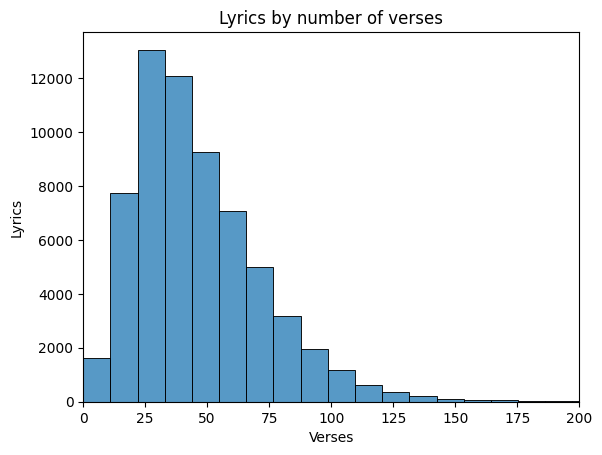

In [25]:
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=50)
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
# There seems to be outliers
ax.set_xlim([0, 200])
plt.show()

In [26]:
# Remove short lyrics
df = df[df['verses']>20]
# Truncate long lyrics
df['lyrics'] = list(map(lambda x: x[:100] if len(x) > 100 else x, df['lyrics']))

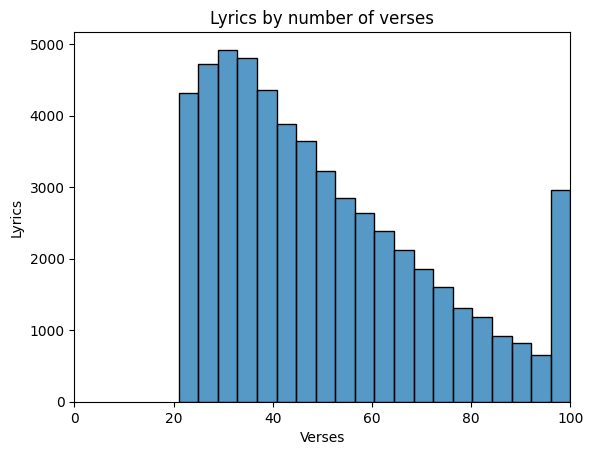

In [27]:
# count number of verses
df['verses'] = df['lyrics'].apply(len)
# Plot distribution
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=20)
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
ax.set_xlim([0, 100])
plt.show()

In [28]:
# Map again dummy variables to labels
df['genre'] = df[['rock', 'pop', 'rap']].apply(lambda x: 'rock' if x[0] == 1 else ('pop' if x[1] == 1 else ('rap' if x[2] == 1 else None)), axis=1)

# Drop dummy variables
df = df.drop(columns=['rock', 'pop', 'rap'])

df.head()

,lyrics,verses,genre
0,"[I feel so unsure, As I take your hand and lea...",47,pop
1,"[Don't let them fool, ya, Or even try to schoo...",28,pop
2,"[Baby, let's cruise, away from here, Don't be ...",26,pop
3,"[Know it sounds funny, But, I just can't stand...",31,pop
4,"[You've got that look again, The one I hoped I...",35,pop


In [29]:
df['genre'].value_counts()

rock    19998
rap     19108
pop     16112
Name: genre, dtype: int64

In [30]:
df.shape

(55218, 3)

## Sampling

In [31]:
df.reset_index(inplace=True, drop=True)
# Keep original index as id incase we want to retrieve samples in original df
df['id'] = df.index

# Create samples taking 100 lyrics by genre
genre_sample150 = [df[df['genre'] == genre_label].sample(n=50, weights='verses', random_state=0) for genre_label in genre_labels]

df_eval = pd.concat(genre_sample150).drop(columns=['verses']).reset_index()

df_eval.to_csv('../data/evaluation/lyrics_eval.csv', index=False)

In [32]:
df.drop(columns=['verses'], inplace=True)
# Save df
df.to_csv('../data/lyrics.csv', index=False)

## Evaluation Dataset Preparation

In [33]:
import pandas as pd
import numpy as np
import random
import ast
from tqdm import tqdm
import nlpaug.augmenter.word as naw
#from textattack.augmentation import EmbeddingAugmenter
#from faker import Faker
from math import sqrt
from sklearn.model_selection import train_test_split

In [34]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [35]:
df.head()

,index,lyrics,genre,id
0,40043,"[""When I'm lyin' in my bed at night"", ""I don't...",rock,40043
1,48922,"['Love is like problems', ""We all got 'em"", 'A...",rock,48922
2,41840,"[""As I was motivatin'"", 'Back in town', 'I saw...",rock,41840
3,39964,"['Oh love, oh love', ""Won't you rain on me ton...",rock,39964
4,37806,"['Take my breath away', ""I don't need it anywa...",rock,37806


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   150 non-null    int64 
 1   lyrics  150 non-null    object
 2   genre   150 non-null    object
 3   id      150 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ KB


In [37]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))

In [38]:
eg_lyrics = random.choice(df['lyrics'])

In [39]:
aug = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")


In [40]:
def misalign_lyrics(lyrics, repetitions, repeat_verse):
    verses2repeat = random.sample(range(0, len(lyrics)), repetitions)
    misaligned_lyrics = []
    for idx, verse in enumerate(lyrics):
        if idx in verses2repeat:
            misaligned_lyrics.extend([verse] * repeat_verse)
        else:
            misaligned_lyrics.append(verse)
    return misaligned_lyrics

In [41]:
idxs2remove = df['id']
all_lyrics = pd.read_csv('../data/lyrics.csv').drop(index=idxs2remove)['lyrics']
all_lyrics = list(map(lambda x: ast.literal_eval(x), all_lyrics))

In [42]:
eg_verse = random.choice(eg_lyrics)
print('Original verse:')
print(eg_verse)

print('Augmented:')
aug.augment(eg_verse)

Original verse:
And then it steals your... soul
Augmented:


['And somehow it stole their soul']

In [43]:
eg_lyrics = random.choice(df['lyrics'])

eg_aug_lyrics = [aug.augment(verse)[0] for verse in tqdm(eg_lyrics)]
eg_aug_misl_lyrics = misalign_lyrics(eg_aug_lyrics, repetitions=round(sqrt(len(eg_lyrics))), repeat_verse=2)

eg_fake_lyrics = random.choice(all_lyrics)

print('ORIGINAL lyrics:')
print(eg_lyrics)
print()
print('AUGMENTED lyrics:')
print('Aligned:')
print(eg_aug_lyrics)
print()
print('Misaligned:')
print(eg_aug_misl_lyrics)
print()
print('RANDOM lyrics:')
print(eg_fake_lyrics)

100%|██████████| 53/53 [00:19<00:00,  2.75it/s]

ORIGINAL lyrics:
['You are rattling my world like an earthquake', "I'm up in the clouds like ooo oo", 'somebody bring me down', "I'm trying to keep you here where it feels great", "but i don't know how to doooo", 'i am losing solid ground', 'dont pinch me', "I'm falling in love, and if i'm dreaming", " baby don't wake me up", 'you got me hoping and wishing', 'that this could last for one more night', 'baby you and me', ' take it to the middle of the dance floor', 'I got what you need', 'tell the DJ keep it spinning on the dance floor', 'and lets go higher', 'lets go high', 'lets go higher', 'lets go high', 'You can set it off if you want it', 'all you gotta do is ooo oo ooo oo', 'your body is calling me', "and i don't wanna have any regrets", "when i'm next to you", 'its like ooo oo ooooo', 'your touch is all i need, oh yeah', 'dont pinch me', "I'm falling in love, and if i'm dreaming", " baby don't wake me up", 'you got me hoping and wishing', 'that this could last for one more night'

In [44]:
augment_many = lambda lyrics: [aug.augment(verse)[0] for verse in lyrics]

aug_lyrics = [augment_many(lyrics) for lyrics in tqdm(df['lyrics'])]
misl_aug_lyrics = [misalign_lyrics(aug_lyr, repetitions=round(sqrt(len(aug_lyr))), repeat_verse=2) for aug_lyr in tqdm(aug_lyrics)]

df['similar_lyrics'] = misl_aug_lyrics
df['random_lyrics'] = random.sample(all_lyrics, len(df['lyrics']))

100%|██████████| 150/150 [00:00<00:00, 32311.93it/s]


In [45]:
df.head()

,index,lyrics,genre,id,similar_lyrics,random_lyrics
0,40043,"[When I'm lyin' in my bed at night, I don't wa...",rock,40043,"[When I'm lyin' with my sisters face first, I ...","[Every night I hope and pray, A dream lover wi..."
1,48922,"[Love is like problems, We all got 'em, A dark...",rock,48922,"[Love spreads like magic, We seriously needed ...","[You can be amazing, You can turn a phrase int..."
2,41840,"[As I was motivatin', Back in town, I saw a Ca...",rock,41840,"[As Katrina was '', Back to town, I saw that p...","[I love it when we're cruisin' together, I lov..."
3,39964,"[Oh love, oh love, Won't you rain on me tonigh...",rock,39964,"[Oh my, no love, Won't you rain down it too?, ...","[Galleria:, When I was just a little girl, my ..."
4,37806,"[Take my breath away, I don't need it anyway, ...",rock,37806,"[Take you breath carefully, I kinda want it an...","[Tuesday seemed like it was thursday, Yesterda..."


In [46]:
df.to_csv('../data/evaluation/lyrics_eval.csv', index=False)